In [129]:
import warnings
warnings.filterwarnings('ignore')

## Imports

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import argmax
from sklearn import svm
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Datasets

In [131]:
seeds_train = pd.read_csv("seeds_train.csv", header = None)
seeds_train.set_axis(["area", "width", "label"], axis = 1, inplace = True)
seeds_test = pd.read_csv("seeds_test.csv", header = None)
seeds_test.set_axis(["area", "width", "label"], axis = 1, inplace = True)

In [132]:
class_names = {
                1: "Kama",
                2: "Rosa",
                3: "Canadian"
              }

## Plotting Functions

In [133]:
def plotData(features, labels, class_names, cls):
    colors = ['r', 'b']
    markers = ['o', '*']
    legend_labels = {}
    
    for key, value in  class_names.items():
        if key == cls:
            legend_labels[1] = class_names[cls]
    legend_labels[-1] = "Others"
    
    for index, clss in enumerate(legend_labels):
        plt.scatter(features[labels == clss, 0], features[labels == clss, 1], c=colors[index], marker=markers[index], label=legend_labels[clss])

    Title = "Wheat Kernels {0} Classifier".format(legend_labels[1])
    plt.title(Title)
    plt.xlabel('Area')
    plt.ylabel('Width')
    plt.legend()

In [134]:
def plotRegions(model,X):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    XX, YY = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    z = model.predict(np.c_[XX.ravel(), YY.ravel()])
    ZZ = z.reshape(XX.shape)
    plt.contourf(XX, YY, ZZ, alpha= 0.2)
 

# Binary Classification

## Data 

In [135]:
binary_train = seeds_train.loc[(seeds_train["label"] == 2) | (seeds_train["label"] == 3)].reset_index(drop=True)
binary_test = seeds_test.loc[(seeds_test["label"] == 2) | (seeds_test["label"] == 3)].reset_index(drop=True)

In [136]:
binary_features_train = binary_train[["area", "width"]]
binary_features_train = np.array(binary_features_train)

binary_labels_train = binary_train["label"]
binary_labels_train = np.array(binary_labels_train)

binary_features_test = binary_test[["area", "width"]]
binary_features_test = np.array(binary_features_test)

binary_labels_test = binary_test["label"]
binary_labels_test = np.array(binary_labels_test)

Text(0, 0.5, 'Width')

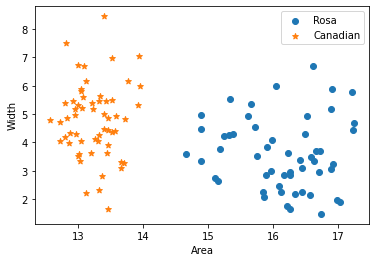

In [137]:
classes = binary_train["label"].unique()
marker = ["o", "*"]
for index, cls in enumerate(classes):
    plt.scatter(binary_features_train[binary_labels_train == cls, 0], binary_features_train[binary_labels_train == cls, 1], label=class_names[cls], marker=marker[index])
plt.legend()
plt.xlabel('Area')
plt.ylabel('Width')

Text(0, 0.5, 'Width')

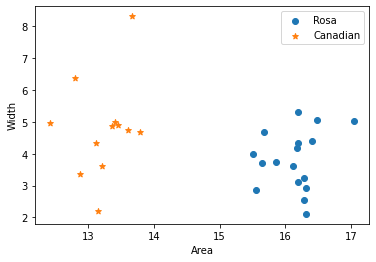

In [138]:
classes = binary_train["label"].unique()
marker = ["o", "*"]
for index, cls in enumerate(classes):
    plt.scatter(binary_features_test[binary_labels_test == cls, 0], binary_features_test[binary_labels_test == cls, 1], label=class_names[cls], marker=marker[index])
plt.legend()
plt.xlabel('Area')
plt.ylabel('Width')

## SVM Binary Classification

1.0
              precision    recall  f1-score   support

           2       1.00      1.00      1.00        17
           3       1.00      1.00      1.00        12

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



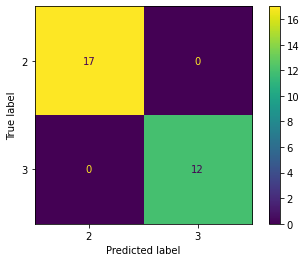

In [139]:
svm_model = svm.SVC(kernel = "linear", random_state = 42)
svm_model.fit(binary_features_train, binary_labels_train)

binary_label_pred = svm_model.predict(binary_features_test)
svm_accuracy = svm_model.score(binary_features_test, binary_labels_test)
print(svm_accuracy)
print(classification_report(binary_labels_test, binary_label_pred))
svm_confusion_matrix = confusion_matrix(binary_labels_test, binary_label_pred)
ConfusionMatrixDisplay(svm_confusion_matrix, display_labels = svm_model.classes_).plot()

## Perceptron Binary Classification 

0.896551724137931
              precision    recall  f1-score   support

           2       0.85      1.00      0.92        17
           3       1.00      0.75      0.86        12

    accuracy                           0.90        29
   macro avg       0.93      0.88      0.89        29
weighted avg       0.91      0.90      0.89        29



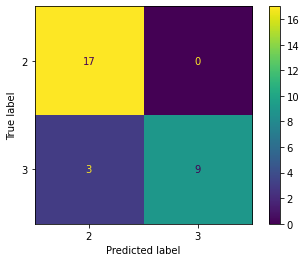

In [140]:
percptron_model = Perceptron(penalty="elasticnet", alpha=0.001, class_weight="balanced", random_state=42)
percptron_model.fit(binary_features_train, binary_labels_train)

binary_label_pred = percptron_model.predict(binary_features_test)
perceptron_accuracy = percptron_model.score(binary_features_test, binary_labels_test)
print(perceptron_accuracy)
print(classification_report(binary_labels_test, binary_label_pred))
perceptron_confusion_matrix = confusion_matrix(binary_labels_test, binary_label_pred)
ConfusionMatrixDisplay(perceptron_confusion_matrix, display_labels = percptron_model.classes_).plot()

# One-versus-Rest

## Model Functions 

In [141]:
def binarize(cls, labels):
    
    label_bin = labels.copy()
    label_bin.loc[labels["label"] == cls, "label"] = 1
    label_bin.loc[labels["label"]  != cls, "label"] = -1

    return label_bin

In [142]:
def model_building(train_features, train_labels, model, cls):
    
    model = model.fit(train_features, train_labels["label"].tolist())

    return model

In [143]:
def model_performance(test_features, test_labels, model, cls):
    
    predictions = model.predict(test_features) 
    pred_prob =  model.predict_proba(test_features) 
    accuracy = model.score(test_features, test_labels["label"].tolist())
    print("Accuracy: ", accuracy*100)
    
    print(classification_report(test_labels["label"].tolist(), predictions))
    conf_mat = confusion_matrix(test_labels["label"].tolist(), predictions)
    ConfusionMatrixDisplay(conf_mat, display_labels = model.classes_).plot()
    plt.figure()
    
    return predictions, pred_prob, 

In [144]:
def model_plotting(test_features, test_labels, model, cls):

    plotData(np.array(test_features), test_labels["label"], class_names, cls)
    plotRegions(model, np.array(test_features))
    plt.figure()


## Data

In [145]:
train_features = seeds_train[["area", "width"]]
train_labels = seeds_train[["label"]]

test_features = seeds_test[["area", "width"]]
test_labels = seeds_test[["label"]]

classes = train_labels["label"].unique()

## SVM One-versus-Rest

Accuracy:  85.71428571428571
              precision    recall  f1-score   support

          -1       0.90      0.90      0.90        29
           1       0.77      0.77      0.77        13

    accuracy                           0.86        42
   macro avg       0.83      0.83      0.83        42
weighted avg       0.86      0.86      0.86        42

Accuracy:  95.23809523809523
              precision    recall  f1-score   support

          -1       1.00      0.92      0.96        25
           1       0.89      1.00      0.94        17

    accuracy                           0.95        42
   macro avg       0.95      0.96      0.95        42
weighted avg       0.96      0.95      0.95        42

Accuracy:  100.0
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        12

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42

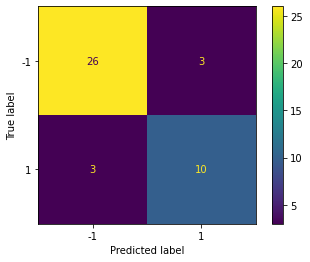

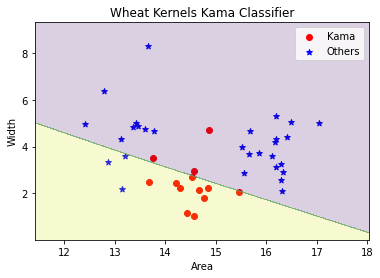

<Figure size 432x288 with 0 Axes>

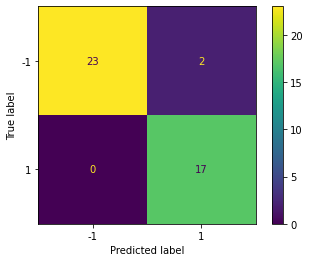

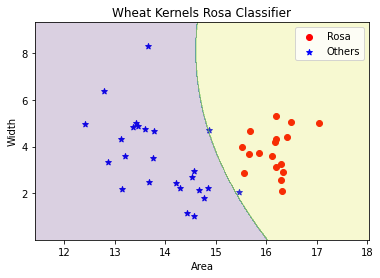

<Figure size 432x288 with 0 Axes>

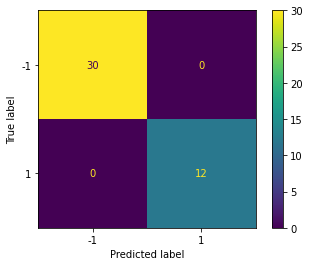

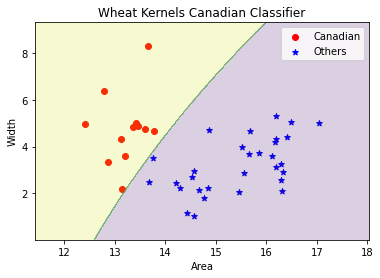

<Figure size 432x288 with 0 Axes>

In [146]:
svm_model = svm.SVC(kernel = "poly", probability = True, random_state = 42)
svm_prediction_probs = []
svm_predictions = []

for cls in classes:
    train_label_bin = binarize(cls, train_labels)
    test_label_bin = binarize(cls, test_labels)
    
    model = model_building(train_features, train_label_bin, svm_model, cls)
    predictions, prediction_probs = model_performance(test_features, test_label_bin, model, cls)
    svm_prediction_probs.append(prediction_probs)
    svm_predictions.append(predictions)
    model_plotting(test_features, test_label_bin, model, cls)

### Argmax

In [147]:
svm_prediction_probs = np.array(svm_prediction_probs) 
svm_predictions = np.array(svm_predictions)
best_pred = argmax(svm_prediction_probs[:, :, 1], axis = 0)

best_pred_classes = []
for pred in best_pred:
    if pred == 0:
        best_pred_classes.append(1)
    if pred == 1:
        best_pred_classes.append(2)
    if pred == 2:
        best_pred_classes.append(3)

Performance

Accuracy: 92.85714285714286


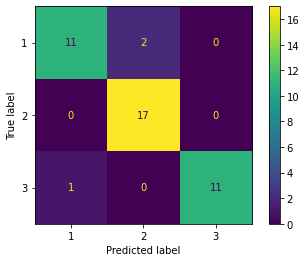

In [148]:
print("Accuracy: {0}".format(classification_report(test_labels["label"].tolist(), best_pred_classes, output_dict=True)["accuracy"]*100))
conf_mat = confusion_matrix(test_labels["label"].tolist(), best_pred_classes)
ConfusionMatrixDisplay(conf_mat, display_labels = class_names).plot()

Plotting Correct and Wrong Predictions

<Figure size 432x288 with 0 Axes>

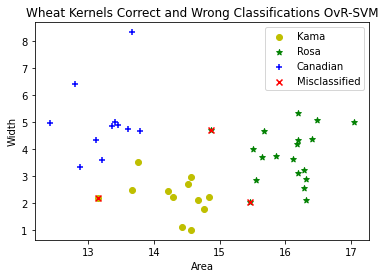

<Figure size 432x288 with 0 Axes>

In [149]:
colors = ['y', 'g', 'b']
markers = ['o', '*', '+']

for index, clss in enumerate(class_names):
    plt.scatter(np.array(test_features)[test_labels.index[np.array(best_pred_classes) == clss], 0], np.array(test_features)[test_labels.index[np.array(best_pred_classes) == clss], 1], c=colors[index], marker=markers[index], label=class_names[clss])
plt.scatter(np.array(test_features)[(np.array(best_pred_classes) != test_labels["label"]).tolist(), 0], np.array(test_features)[(np.array(best_pred_classes) != test_labels["label"]).tolist(), 1], c='r', marker='x', label="Misclassified")

Title = "Wheat Kernels Correct and Wrong Classifications OvR-SVM"
plt.title(Title)
plt.xlabel('Area')
plt.ylabel('Width')
plt.legend()
plt.figure()

### Alternative Aggregation Strategy: KNN Votes

In [150]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_features, train_labels["label"].tolist())

best_pred = []
for index in range(len(test_labels)):
    votes = knn.kneighbors([test_features.iloc[index].tolist()], n_neighbors = 3, return_distance = False)
    votes = train_labels["label"].iloc[votes[0].tolist()]
    
    c1_vote = np.count_nonzero(votes == 1)
    c2_vote = np.count_nonzero(votes == 2)
    c3_vote = np.count_nonzero(votes == 3)
    vote = [svm_prediction_probs[0, index, 1]*c1_vote, svm_prediction_probs[1, index, 1]*c2_vote, svm_prediction_probs[2, index, 1]*c3_vote]
    best_pred.append(argmax(vote))
    
best_pred_classes = []
for pred in best_pred:
    if pred == 0:
        best_pred_classes.append(1)
    if pred == 1:
        best_pred_classes.append(2)
    if pred == 2:
        best_pred_classes.append(3)

Performance

0.9523809523809523


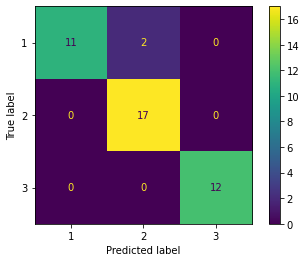

In [151]:
print("Accuracy: ".format(classification_report(test_labels["label"].tolist(), best_pred_classes, output_dict=True)["accuracy"]*100))
conf_mat = confusion_matrix(test_labels["label"].tolist(), best_pred_classes)
ConfusionMatrixDisplay(conf_mat, display_labels = class_names).plot()

Plotting Correct and Wrong Predictions

<Figure size 432x288 with 0 Axes>

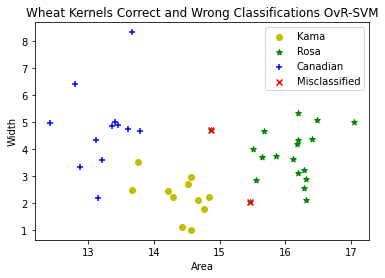

<Figure size 432x288 with 0 Axes>

In [152]:
colors = ['y', 'g', 'b']
markers = ['o', '*', '+']

for index, clss in enumerate(class_names):
    plt.scatter(np.array(test_features)[test_labels.index[np.array(best_pred_classes) == clss], 0], np.array(test_features)[test_labels.index[np.array(best_pred_classes) == clss], 1], c=colors[index], marker=markers[index], label=class_names[clss])
plt.scatter(np.array(test_features)[(np.array(best_pred_classes) != test_labels["label"]).tolist(), 0], np.array(test_features)[(np.array(best_pred_classes) != test_labels["label"]).tolist(), 1], c='r', marker='x', label="Misclassified")

Title = "Wheat Kernels Correct and Wrong Classifications OvR-SVM"
plt.title(Title)
plt.xlabel('Area')
plt.ylabel('Width')
plt.legend()
plt.figure()

## Perceptron One-versus-Rest

Accuracy:  88.09523809523809
              precision    recall  f1-score   support

          -1       0.90      0.93      0.92        29
           1       0.83      0.77      0.80        13

    accuracy                           0.88        42
   macro avg       0.87      0.85      0.86        42
weighted avg       0.88      0.88      0.88        42

Accuracy:  97.61904761904762
              precision    recall  f1-score   support

          -1       1.00      0.96      0.98        25
           1       0.94      1.00      0.97        17

    accuracy                           0.98        42
   macro avg       0.97      0.98      0.98        42
weighted avg       0.98      0.98      0.98        42

Accuracy:  97.61904761904762
              precision    recall  f1-score   support

          -1       0.97      1.00      0.98        30
           1       1.00      0.92      0.96        12

    accuracy                           0.98        42
   macro avg       0.98      0.96      0.

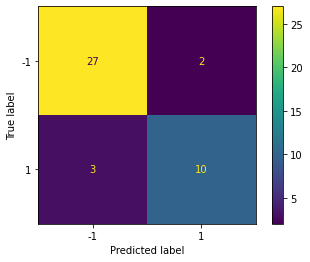

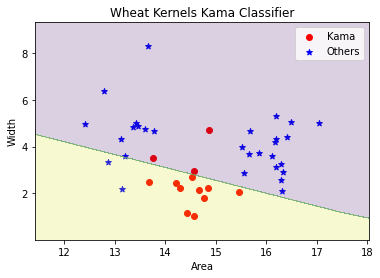

<Figure size 432x288 with 0 Axes>

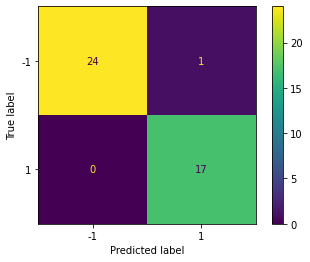

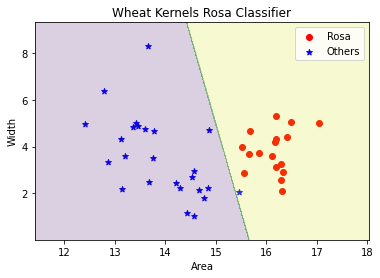

<Figure size 432x288 with 0 Axes>

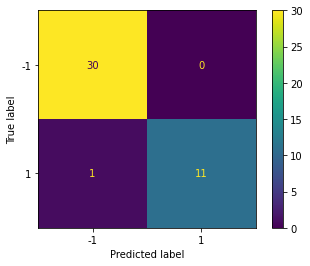

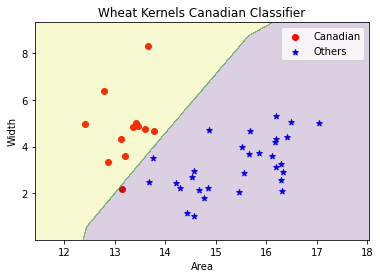

<Figure size 432x288 with 0 Axes>

In [153]:
perceptron_model = MLPClassifier(solver = "adam", learning_rate_init = 0.01, max_iter = 450, hidden_layer_sizes = 30, random_state = 42)
perc_prediction_probs = []
perc_predictions = []

for cls in classes:
    train_label_bin = binarize(cls, train_labels)
    test_label_bin = binarize(cls, test_labels)
    
    model = model_building(train_features, train_label_bin, perceptron_model, cls)
    predictions, prediction_probs = model_performance(test_features, test_label_bin, model, cls)
    perc_prediction_probs.append(prediction_probs)
    perc_predictions.append(predictions)
    model_plotting(test_features, test_label_bin, model, cls)

### Argmax

In [154]:
perc_prediction_probs = np.array(perc_prediction_probs) 
perc_predictions = np.array(perc_predictions)
best_pred = argmax(perc_prediction_probs[:, :, 1], axis = 0)

best_pred_classes = []
for pred in best_pred:
    if pred == 0:
        best_pred_classes.append(1)
    if pred == 1:
        best_pred_classes.append(2)
    if pred == 2:
        best_pred_classes.append(3)

Performance

Accuracy: 95.23809523809523


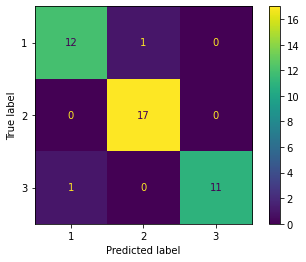

In [155]:
print("Accuracy: {0}".format(classification_report(test_labels["label"].tolist(), best_pred_classes, output_dict=True)["accuracy"]*100))
conf_mat = confusion_matrix(test_labels["label"].tolist(), best_pred_classes)
ConfusionMatrixDisplay(conf_mat, display_labels = class_names).plot()

Plotting Correct and Wrong Predictions

<Figure size 432x288 with 0 Axes>

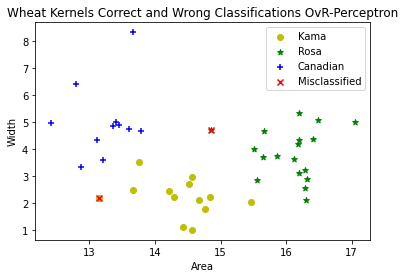

<Figure size 432x288 with 0 Axes>

In [156]:
colors = ['y', 'g', 'b']
markers = ['o', '*', '+']

for index, clss in enumerate(class_names):
    plt.scatter(np.array(test_features)[test_labels.index[np.array(best_pred_classes) == clss], 0], np.array(test_features)[test_labels.index[np.array(best_pred_classes) == clss], 1], c=colors[index], marker=markers[index], label=class_names[clss])
plt.scatter(np.array(test_features)[(np.array(best_pred_classes) != test_labels["label"]).tolist(), 0], np.array(test_features)[(np.array(best_pred_classes) != test_labels["label"]).tolist(), 1], c='r', marker='x', label="Misclassified")

Title = "Wheat Kernels Correct and Wrong Classifications OvR-Perceptron"
plt.title(Title)
plt.xlabel('Area')
plt.ylabel('Width')
plt.legend()
plt.figure()

### Alternative Aggregation Strategy: KNN Votes

In [157]:
best_pred = []
for index in range(len(test_labels)):
    votes = knn.kneighbors([test_features.iloc[index].tolist()], n_neighbors = 2, return_distance = False)
    votes = train_labels["label"].iloc[votes[0].tolist()]
    
    c1_vote = np.count_nonzero(votes == 1)
    c2_vote = np.count_nonzero(votes == 2)
    c3_vote = np.count_nonzero(votes == 3)
    vote = [perc_prediction_probs[0, index, 1]*c1_vote, perc_prediction_probs[1, index, 1]*c2_vote, perc_prediction_probs[2, index, 1]*c3_vote]
    best_pred.append(argmax(vote))
    
best_pred_classes = []
for pred in best_pred:
    if pred == 0:
        best_pred_classes.append(1)
    if pred == 1:
        best_pred_classes.append(2)
    if pred == 2:
        best_pred_classes.append(3)

Performance

0.9523809523809523


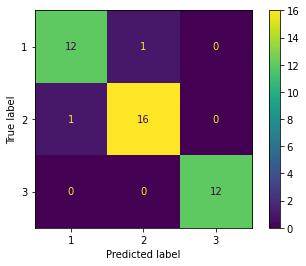

In [158]:
print("Accuracy: {0}".formay(classification_report(test_labels["label"].tolist(), best_pred_classes, output_dict=True)["accuracy"]*100))
conf_mat = confusion_matrix(test_labels["label"].tolist(), best_pred_classes)
ConfusionMatrixDisplay(conf_mat, display_labels = class_names).plot()

Plotting Correct and Wrong Predictions

<Figure size 432x288 with 0 Axes>

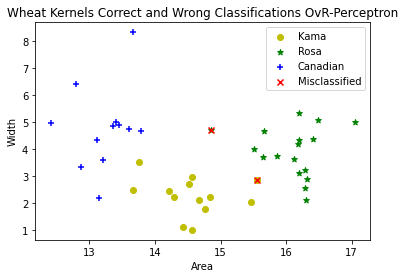

<Figure size 432x288 with 0 Axes>

In [159]:
colors = ['y', 'g', 'b']
markers = ['o', '*', '+']

for index, clss in enumerate(class_names):
    plt.scatter(np.array(test_features)[test_labels.index[np.array(best_pred_classes) == clss], 0], np.array(test_features)[test_labels.index[np.array(best_pred_classes) == clss], 1], c=colors[index], marker=markers[index], label=class_names[clss])
plt.scatter(np.array(test_features)[(np.array(best_pred_classes) != test_labels["label"]).tolist(), 0], np.array(test_features)[(np.array(best_pred_classes) != test_labels["label"]).tolist(), 1], c='r', marker='x', label="Misclassified")

Title = "Wheat Kernels Correct and Wrong Classifications OvR-Perceptron"
plt.title(Title)
plt.xlabel('Area')
plt.ylabel('Width')
plt.legend()
plt.figure()